In [12]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import scipy.interpolate as scint
import numpy as np
import time
from custom_layer import ScaleAngles
import os; import subprocess; import sys

# replace the argparse / sys.argv code with a notebook-relative path
nb_dir = os.getcwd()   # notebook working directory (where the .ipynb is opened)
infile = os.path.join(nb_dir, "models", "2025-12-13_model3.keras")

# ensure expansion and show status for debugging
infile = os.path.expanduser(infile)
print("Using model file:", infile, "exists:", os.path.exists(infile))

Using model file: /Users/danny/Documents/Courses/Year 4/Code/mldirc/dense/film/models/2025-12-13_model3.keras exists: True


In [13]:



import os, sys, tensorflow as tf
print("sys.executable:", sys.executable)
print("cwd:", os.getcwd())
print("path exists (raw):", os.path.exists(infile))
path = os.path.expanduser(infile)
print("expanded path:", path, "exists:", os.path.exists(path))
print("TF version:", tf.__version__, "Keras:", tf.keras.__version__)
# after loading model:

indata = np.load('iahits2.npz', mmap_mode='r')
TIMES = indata['TIMES']; MOM = indata['ANGLES']; LABELS = indata['LABELS']

theta = np.arccos(MOM.T[6])*180/np.pi

model = keras.models.load_model(infile)

nevents = TIMES.shape[0]

t1 = time.time()
# Make predictions on full dataset
predictions = model.predict((TIMES, MOM), verbose=0)
pred_labels = np.argmax(predictions, axis=1)

t2 = time.time()

print(f'[INFO] Evaluated {nevents} events in {t2-t1} seconds;\n{((t2-t1)/nevents) * 10**6} µs per event')

sys.executable: /Users/danny/rabbit/bin/python
cwd: /Users/danny/Documents/Courses/Year 4/Code/mldirc/dense/film
path exists (raw): True
expanded path: /Users/danny/Documents/Courses/Year 4/Code/mldirc/dense/film/models/2025-12-13_model3.keras exists: True
TF version: 2.20.0 Keras: 3.11.3
[INFO] Evaluated 688800 events in 20.65123414993286 seconds;
29.981466535907174 µs per event


In [14]:

# Define theta bins: 1 unit per bin
theta_min = np.floor(np.min(theta))
theta_max = np.ceil(np.max(theta))

print(theta_min)
print(theta_max)

bin_edges = np.arange(theta_min, theta_max + 1, 1.0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


accuracies = []
bin_counts = []

for i in range(len(bin_edges) - 1):
    mask = (theta >= bin_edges[i]) & (theta < bin_edges[i + 1])
    
    if np.sum(mask) == 0:
        accuracies.append(np.nan)
        bin_counts.append(0)
        continue

    correct = np.sum(pred_labels[mask] == LABELS[mask])
    total = np.sum(mask)
    acc = correct / total
    
    accuracies.append(acc)
    bin_counts.append(total)
    
    print(f"Theta [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}): "
          f"accuracy={acc:.4f}, n={total}")

accuracies = np.array(accuracies)


39.0
90.0
Theta [39.00, 40.00): accuracy=0.7056, n=8534
Theta [40.00, 41.00): accuracy=0.6970, n=16693
Theta [41.00, 42.00): accuracy=0.6919, n=16723
Theta [42.00, 43.00): accuracy=0.6625, n=16808
Theta [43.00, 44.00): accuracy=0.6490, n=16827
Theta [44.00, 45.00): accuracy=0.6542, n=16741
Theta [45.00, 46.00): accuracy=0.6572, n=16899
Theta [46.00, 47.00): accuracy=0.6434, n=16875
Theta [47.00, 48.00): accuracy=0.6448, n=16727
Theta [48.00, 49.00): accuracy=0.6366, n=16804
Theta [49.00, 50.00): accuracy=0.6388, n=16792
Theta [50.00, 51.00): accuracy=0.6384, n=16772
Theta [51.00, 52.00): accuracy=0.6315, n=16859
Theta [52.00, 53.00): accuracy=0.6334, n=16774
Theta [53.00, 54.00): accuracy=0.6361, n=16928
Theta [54.00, 55.00): accuracy=0.6286, n=16627
Theta [55.00, 56.00): accuracy=0.6318, n=16673
Theta [56.00, 57.00): accuracy=0.6318, n=16828
Theta [57.00, 58.00): accuracy=0.6341, n=16957
Theta [58.00, 59.00): accuracy=0.6409, n=16711
Theta [59.00, 60.00): accuracy=0.6277, n=16766
Thet

In [ ]:

photon_counts = np.count_nonzero(TIMES, axis=1)

max_ph = int(photon_counts.max())
ph_bins = np.arange(0, max_ph + 1)  # each integer photon count
ph_centers = ph_bins  # integer centers

ph_accuracies = []
ph_counts = []
ph_sigma = []

for k in ph_bins:
    mask = (photon_counts == k)
    n = np.sum(mask)
    acc = np.sum(pred_labels[mask] == LABELS[mask]) / n
    if n <= 10 or acc == 1:
        ph_accuracies.append(np.nan)
        ph_counts.append(0)
        ph_sigma.append(np.nan)
        continue
    
    ph_accuracies.append(acc)
    ph_counts.append(n)
    print(np.sqrt(acc * (1 - acc) / n))
    ph_sigma.append(np.sqrt(acc * (1 - acc) / n))

ind = np.argwhere(ph_counts).flatten()

ph_accuracies = np.array(ph_accuracies)[ind]
ph_counts = np.array(ph_counts)[ind]
ph_sigma = np.array(ph_sigma)[ind]
ph_centers = np.array(ph_centers)[ind]

print(ph_sigma)

itp = scint.UnivariateSpline(ph_centers, ph_accuracies, w=1/ph_sigma)
itp_xs = np.linspace(np.min(ph_centers), np.max(ph_centers), 1000)


print(itp(itp_xs))


0.0
[0.]


/var/folders/tf/1r5qs6dj38195393y3w6rfqm0000gn/T/ipykernel_61604/1396903707.py:34: RuntimeWarning: divide by zero encountered in divide
  itp = scint.UnivariateSpline(ph_centers, ph_accuracies, w=1/ph_sigma)


error: (m>k) failed for hidden m: fpcurf0:m=1

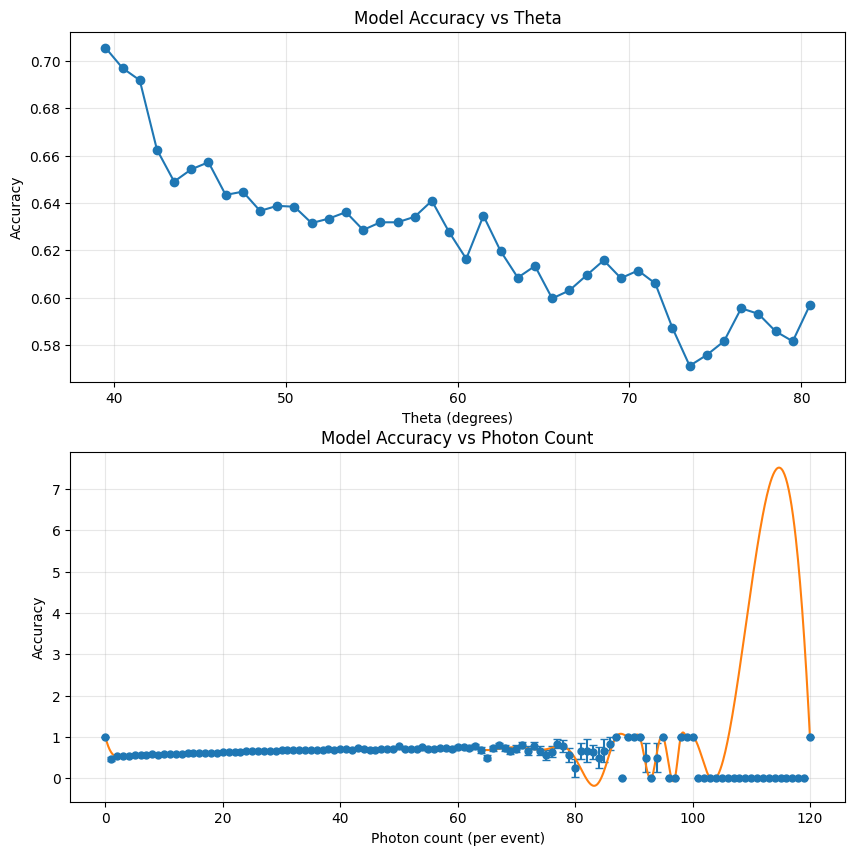

In [27]:

# plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

ax1.errorbar(bin_centers, accuracies, fmt='o-', capsize=4, markersize=6)
ax1.set_xlabel('Theta (degrees)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy vs Theta')
ax1.grid(True, alpha=0.3)

ax2.errorbar(ph_centers, ph_accuracies, yerr=ph_sigma, fmt='o', capsize=3, markersize=5)
ax2.plot(itp_xs, itp(itp_xs))
ax2.set_xlabel('Photon count (per event)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy vs Photon Count')
ax2.grid(True, alpha=0.3)